# Assignment 3 - Dimension Reduction and Spatial temporal Modelling

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt

plt.rcParams["image.cmap"] = 'RdBu_r'

In [2]:
filename = 'CentralAmericaPrecAnomalyGHCN.nc'
DS = xr.open_dataset(filename)
DS

<xarray.Dataset>
Dimensions:    (LON: 76, LAT: 40, TIME: 300, bnds: 2)
Coordinates:
  * LON        (LON) float32 240.2 240.8 241.2 241.8 ... 276.2 276.8 277.2 277.8
  * LAT        (LAT) float32 10.25 10.75 11.25 11.75 ... 28.25 28.75 29.25 29.75
  * TIME       (TIME) datetime64[ns] 1990-01-01 1990-02-01 ... 2014-12-01
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (TIME, bnds) datetime64[ns] ...
    PREC_ANOM  (TIME, LAT, LON) float64 ...
Attributes:
    history:      Thu Apr  1 11:18:10 2021: ncrename -d LON481_556,LON -v LON...
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...

Convert the data to pandas dataframe for ease of managing it. I will also preprocess the data such that we end up with latitude, longitude and precipitation_anomaly values at each timestep

In [3]:
prec_anom_df = DS.to_dataframe().reset_index()
prec_anom_df = prec_anom_df.loc[prec_anom_df.bnds==0].drop(columns=['bnds', 'TIME_bnds']).reset_index(drop=True)
prec_anom_df.loc[:, 'TIME'] = pd.to_datetime(prec_anom_df.loc[:, 'TIME'])
prec_anom_df = prec_anom_df.sort_values(['TIME', 'LON', 'LAT'])
prec_anom_df.sample(5)

,LON,LAT,TIME,PREC_ANOM
128414,245.25,24.25,1991-03-01,NaN
225848,249.25,26.25,2010-09-01,NaN
905350,277.75,18.75,2010-11-01,NaN
663840,267.75,16.25,2010-01-01,0.4872
68439,242.75,24.25,1993-04-01,NaN


In [17]:
n_time = prec_anom_df.TIME.nunique()
n_lon = prec_anom_df.LON.nunique()
n_lat = prec_anom_df.LAT.nunique()
date_list = prec_anom_df.TIME.unique()

### Utility Functions

In [6]:
def plot_timeseries(lon, lat, df):
    fig, ax = plt.subplots(figsize=(15, 4))
    df.loc[ (prec_anom_df.LON==(249.75)) & (df.LAT==28.75)].plot(x='TIME', y='PREC_ANOM', ax=ax)
    plt.xlabel('TIME')
    plt.ylabel('PRECIPITATION ANOMALY (cm)')
    

In [96]:
def plot_colormap(data, date=None, col='PREC_ANOM', data_as_matrix=False, clim=None):
    
    # Filter data by date
    if not data_as_matrix:
        df_time = data.loc[data.TIME == date]
        prec_anom = df_time.loc[:, col].values.reshape(n_lon, n_lat)
    else:
        prec_anom = data
    
    # X-axis grid
    X = prec_anom_df.LON.unique()
    X = np.tile(X, n_lat).reshape(n_lat, n_lon)
    
    # Y-axis grid
    Y = prec_anom_df.LAT.unique().T
    Y = np.tile(Y, n_lon).reshape(n_lon, n_lat).T

    # Plot
    plt.figure(figsize=(8, 5))
    plt.pcolor(X, Y, prec_anom.T, shading='auto')
    plt.colorbar()
    if date is not None:
        plt.title(f'PERCIPITATION ANOMALY on {str(date.date())}')
    if clim is not None:
        plt.clim(clim)
    
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')

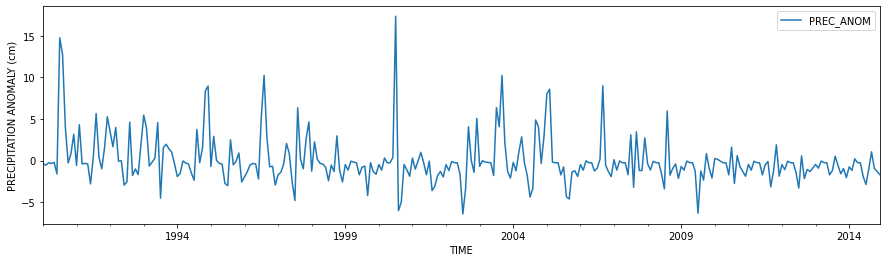

In [92]:
plot_timeseries(lon=294.75, lat=110.75, df=prec_anom_df)

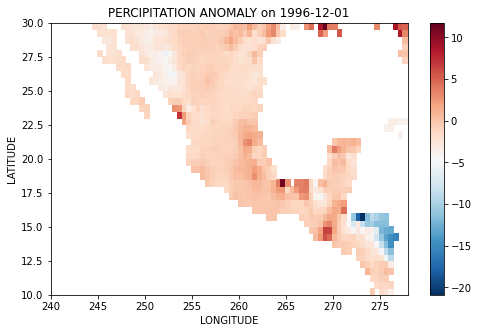

In [93]:
select_date = dt.datetime(1996,12,1)
plot_colormap(date=select_date, data=prec_anom_df)

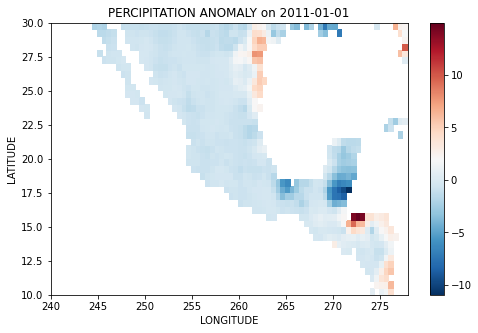

In [94]:
select_date = dt.datetime(2011,1,1)
plot_colormap(date=select_date, data=prec_anom_df)

Adjust precipitation values based on the latitudes

In [32]:
prec_anom_df.loc[:, 'WEIGHTED_PREC_ANOM'] = prec_anom_df.loc[:, 'PREC_ANOM']\
                                    * np.cos(np.deg2rad(prec_anom_df.loc[:, 'LAT']))

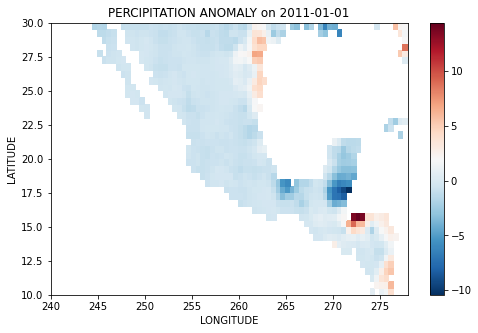

In [43]:
plot_colormap(date=select_date, data=prec_anom_df, col='WEIGHTED_PREC_ANOM')

### Part 1: 1st Empirical Orthogonal Function (EOF) and Principle Component (PC) of Rainfall anomaly

In [34]:
cols_to_select = ['TIME', 'LON', 'LAT', 'WEIGHTED_PREC_ANOM']
df_for_eof = prec_anom_df[cols_to_select].sort_values(cols_to_select[:-1]).reset_index(drop=True)
df_for_eof.tail()

,TIME,LON,LAT,WEIGHTED_PREC_ANOM
911995,2014-12-01,277.75,27.75,-3.718718
911996,2014-12-01,277.75,28.25,-0.694142
911997,2014-12-01,277.75,28.75,0.824824
911998,2014-12-01,277.75,29.25,1.388316
911999,2014-12-01,277.75,29.75,-1.123102


In [35]:
data_as_matrix = np.zeros((n_time, n_lon * n_lat))

for date_idx in range(n_time):
    data_as_matrix[date_idx] = df_for_eof.loc[df_for_eof.TIME==date_list[date_idx], 'WEIGHTED_PREC_ANOM'].values

In [36]:
data_as_matrix.shape

(300, 3040)

In [37]:
data_as_matrix = np.nan_to_num(data_as_matrix)
u, s, vh = np.linalg.svd(data_as_matrix, full_matrices=True) 

print(u.shape)
print(s.shape)
print(vh.shape)

(300, 300)
(300,)
(3040, 3040)


#### 1st Empirical Orthogonal Component

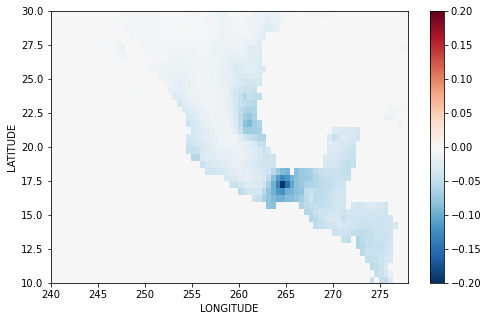

In [102]:
# 1st EOF of rainfall anomaly
EOF1 = vh[0]

# Rescale the eof
weights = np.cos(np.deg2rad(prec_anom_df.loc[prec_anom_df.TIME==select_date, 'LAT'])).values
EOF1 = EOF1 / weights

EOF1_mat = EOF1.reshape((n_lon, n_lat))

# Plot the EOF
plot_colormap(data=EOF1_mat, data_as_matrix=True, clim=(-.2, .2))

#### 1st Principle Component

Text(0.5, 0, 'TIME')

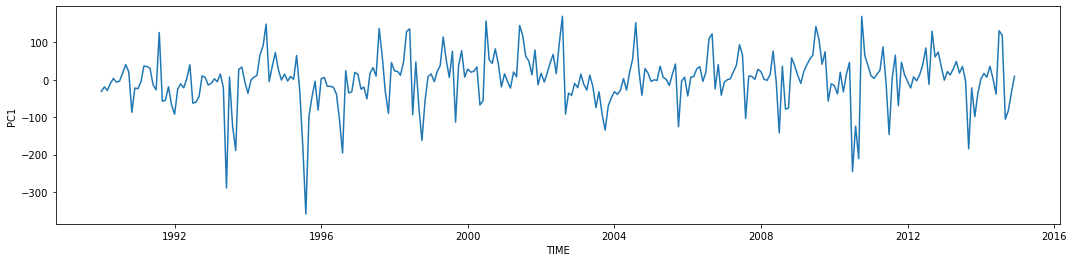

In [83]:
# 1st PC
PC1 = data_as_matrix @ EOF1

plt.figure(figsize=(18, 4))
plt.plot(prec_anom_df.TIME.unique(), PC1)
plt.ylabel('PC1')
plt.xlabel('TIME')

### Part 2: What fraction of the total variance is explained by your first EOF? 

Text(0, 0.5, 'Eigenvalue')

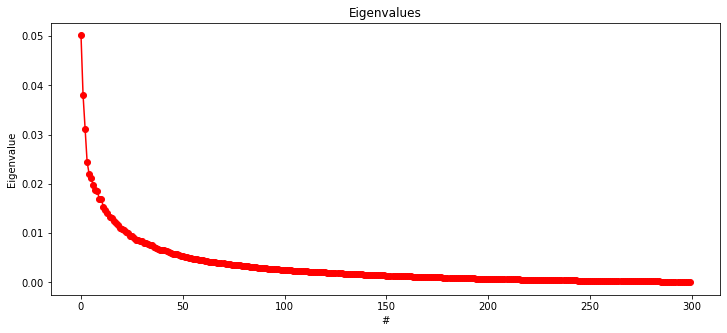

In [84]:
sorted_sigma = s[np.argsort(s)]

plt.figure(figsize=(12, 5))
plt.plot(np.flipud(sorted_sigma)/np.sum(s),'ro-')
plt.title('Eigenvalues') 
plt.xlabel('#')
plt.ylabel('Eigenvalue')

**Ans:** Approximately, $\mathbf{5\%}$ of the total variance in rainfall anomaly is explained by the first EOF

### Part 3

One common use of EOFs is to guide further analysis of high-dimensional data. 
1. Based on your result, which region of Mexico experiences the least variation in rainfall? 
2. Can you guess which part of the country experiences the most extreme rainfall events?

Text(0, 0.5, '% variance explained')

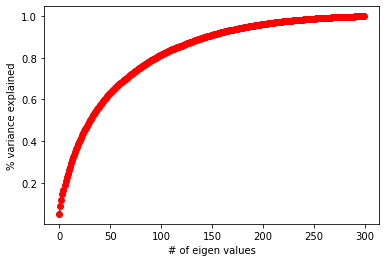

In [85]:
plt.plot(np.cumsum(np.flipud(sorted_sigma))/np.sum(sorted_sigma), 'ro-')
plt.xlabel('# of eigen values')
plt.ylabel('% variance explained')

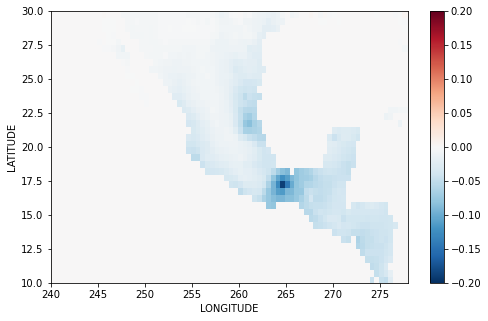

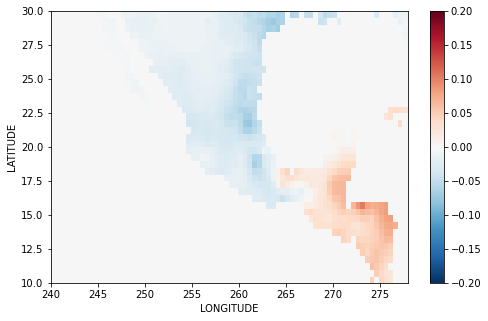

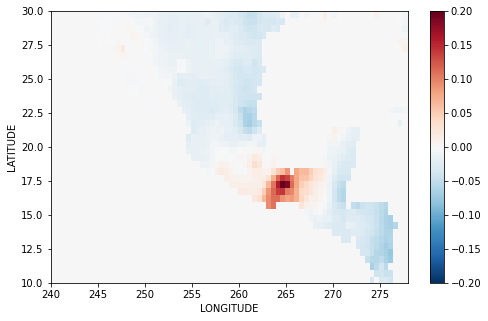

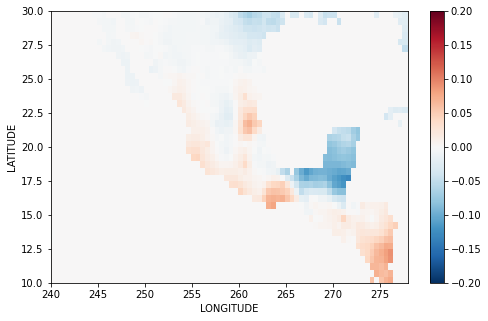

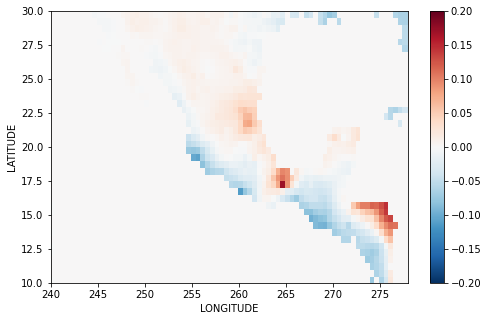

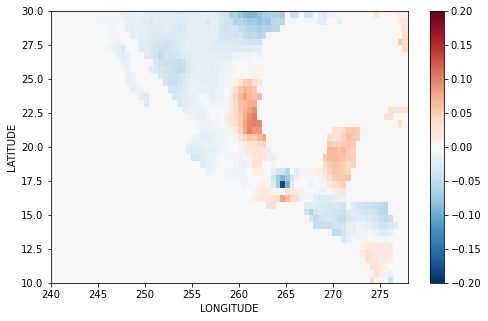

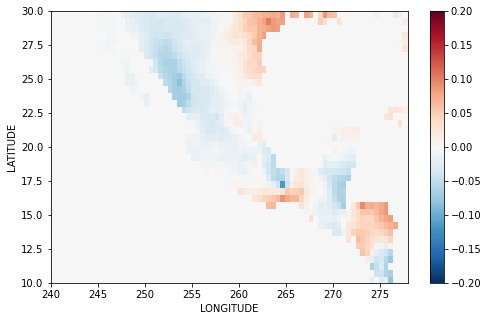

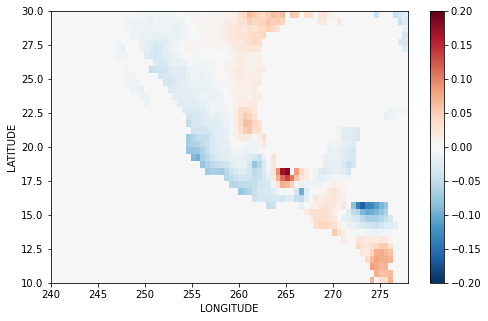

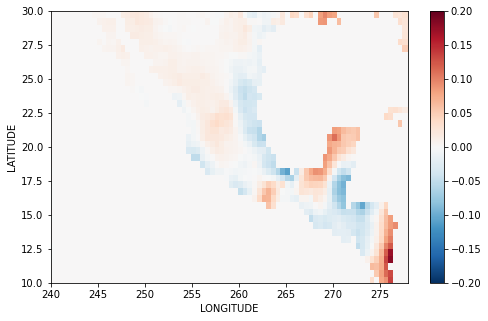

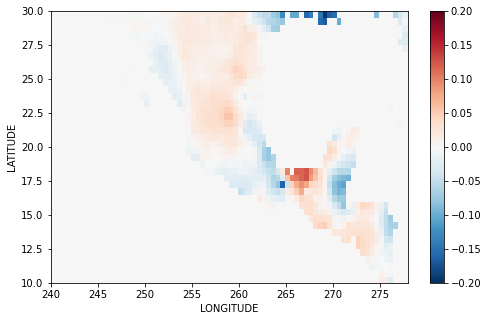

In [103]:
# 1st EOF of rainfall anomaly
n= 10
for i in range(n):
    EOF = vh[i]
    EOF_mat = EOF.reshape((n_lon, n_lat))

    # Plot the EOF
    plot_colormap(data=EOF_mat, data_as_matrix=True, clim=(-.2, .2))

**Ans:** Based on the variances explained by the EOFs:
1. We can say that the north-west quadrant of Mexico shows least variance in the rainfall. 
2. While the coastal region in the south-east quadrant experiences most extreme rainfall events